In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, uniform, gamma

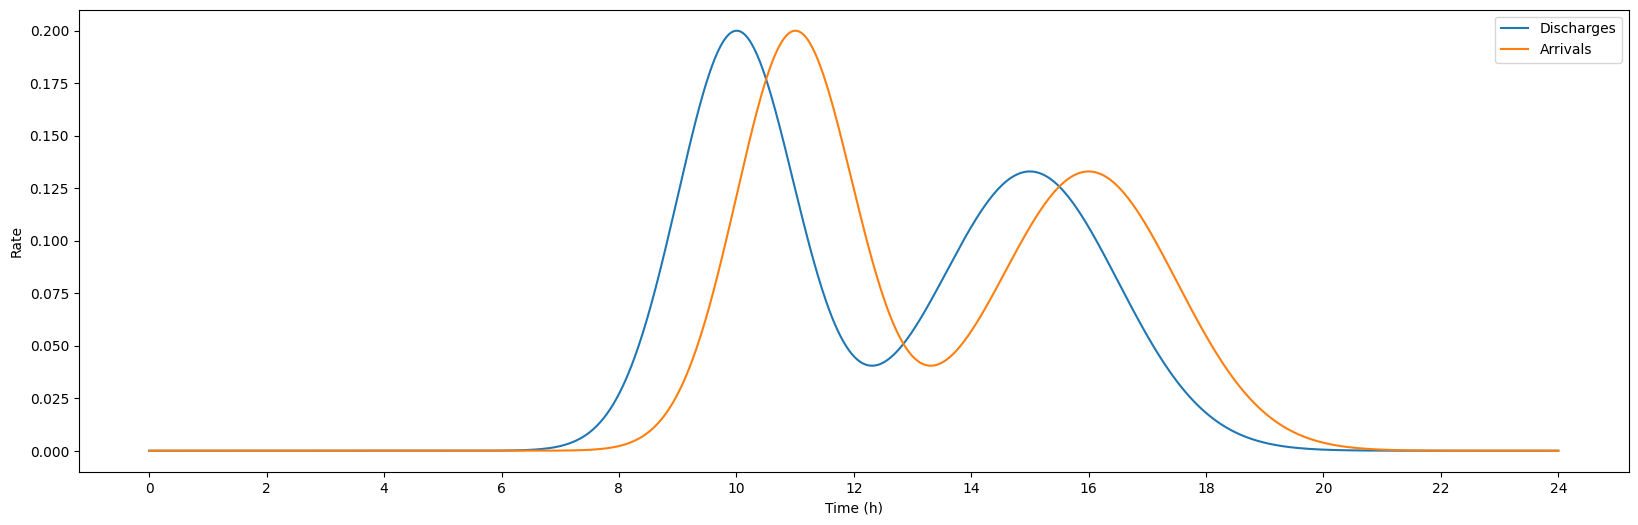

In [2]:
p_ = 0.55
t_ = np.linspace(0, 24, 1000)

class ArrivalDistribution:
    first_round_time = 9
    second_round_time = 15
    def __init__(self, p=0.5, offset=0):
        self.p = p
        self.first_peak = norm(loc=10 + offset, scale=1)
        self.second_peak = norm(loc=15 + offset, scale=1.5)

    def pdf(self, x):
        return self.p * self.first_peak.pdf(x) + (1 - self.p) * self.second_peak.pdf(x)

    def rvs(self, size=()):
        s1 = self.first_peak.rvs(size=size)
        s2 = self.second_peak.rvs(size=size)
        choice = uniform.rvs(size=size) < self.p
        return np.where(choice, s1, s2)

discharge_dist = ArrivalDistribution()
admission_dist = ArrivalDistribution(offset=1)


fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.plot(t_, discharge_dist.pdf(t_), label="Discharges")
ax.plot(t_, admission_dist.pdf(t_), label="Arrivals")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Rate")
ax.set_xticks(np.arange(0, 25, 2), np.arange(0, 25, 2))
ax.legend()
plt.show()

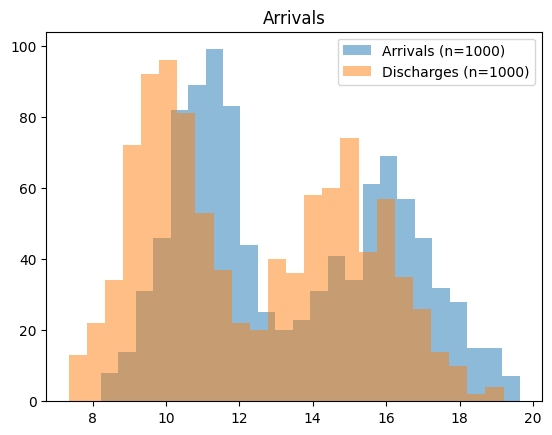

In [3]:
arrivals = admission_dist.rvs(size=1000)
discharges = discharge_dist.rvs(size=1000)

plt.title("Arrivals")
plt.hist(arrivals, alpha=0.5, bins=24, label=f"Arrivals (n={len(arrivals)})")
plt.hist(discharges, alpha=0.5, bins=24, label=f"Discharges (n={len(discharges)})")
plt.legend()
plt.show()

## Timeline of a bed
All the while the bed may have to wait for available transport and washing. 
- Patient is admitted to the hospital and occupies a bed.
- Patient is discharged, and the bed is sent to the logistics floor.
- Bed is transported from the elevator to the washing area.
- Bed is washed.
- Bed is transported back to the elevator.

In [4]:
from simulation_loop import simulate_system, simulate_many, SimulationParams

np.random.seed(42069)

def service_time_dist():
    service_min_time = 5/60
    return service_min_time + expon(scale=1/60).rvs()


def transport_time_dist(distance_meters):
    if distance_meters == 0:
        return 0
    speed_meters_per_second = 1.4
    transport_time_seconds = gamma(a=distance_meters, scale=1/speed_meters_per_second).rvs()
    return transport_time_seconds / 3600

distances = np.array([
    [10, 175, 0],
    [175, 10, 175],
    [0, 175, 10],
])

n_elevators = 2

params = SimulationParams(
    discharge_dist,
    admission_dist,
    service_time_dist,
    transport_time_dist,
    distances,
    arrival_weights=np.ones(n_elevators) / n_elevators,
    discharge_weights=np.ones(n_elevators) / n_elevators,
    n_elevators=n_elevators,
    n_robots=2,
    n_patients=100
)

events, data = simulate_system(params)

In [5]:
for e in events:
    if hasattr(e, "robot_id"):
        e.print()

[07:52:05] RobotsDispatched(time=np.float64(7.868147729897972), robot_id=np.int64(0))
[07:52:05] PickUpBed(time=np.float64(7.868147729897972), robot_id=np.int64(0), location_id=np.int64(2), buffer=<Buffer.DIRTY: 0>)
[07:52:05] DropOffBed(time=np.float64(7.868147729897972), robot_id=np.int64(0), location_id=0, buffer=<Buffer.DIRTY: 0>)
[07:57:07] RobotsDispatched(time=np.float64(7.9521050126812325), robot_id=np.int64(0))
[07:57:15] PickUpBed(time=np.float64(7.954255664080732), robot_id=np.int64(0), location_id=0, buffer=<Buffer.CLEAN: 1>)
[07:57:15] DropOffBed(time=np.float64(7.954255664080732), robot_id=np.int64(0), location_id=np.int64(2), buffer=<Buffer.CLEAN: 1>)
[08:06:49] RobotsDispatched(time=np.float64(8.113789033468564), robot_id=np.int64(0))
[08:08:56] PickUpBed(time=np.float64(8.149014376661427), robot_id=np.int64(0), location_id=np.int64(1), buffer=<Buffer.DIRTY: 0>)
[08:11:07] DropOffBed(time=np.float64(8.185336392280847), robot_id=np.int64(0), location_id=0, buffer=<Buffer

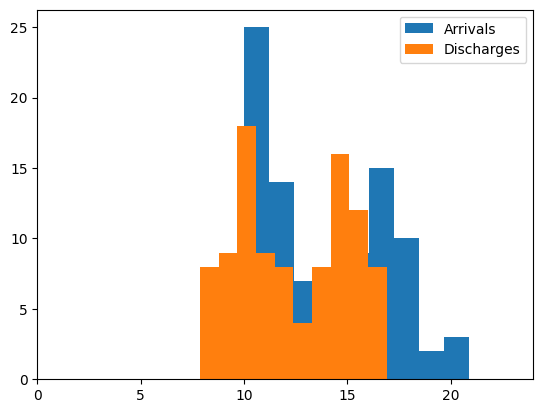

In [6]:
plt.hist(data["arrivals"], label="Arrivals")
plt.hist(data["discharges"], label="Discharges")
plt.legend()
plt.xlim(0, 24)
plt.show()

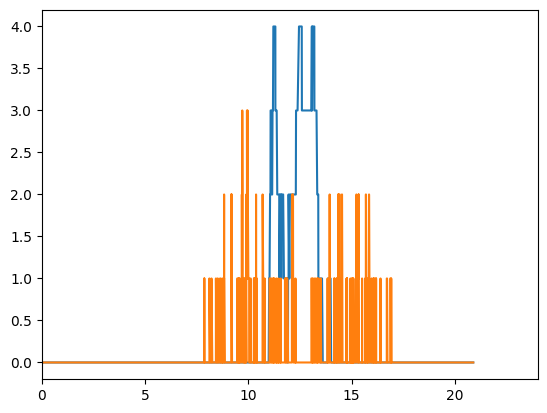

In [7]:
plt.plot(data["times"], data["demands"][1])
plt.plot(data["times"], np.sum(data["buffers"][0, 1:], axis=0))
plt.xlim(0, 24)
plt.show()

In [8]:
buffers, demand = simulate_many(params, n_iters=10)

ValueError: too many values to unpack (expected 2)

IndexError: index 2 is out of bounds for axis 1 with size 2

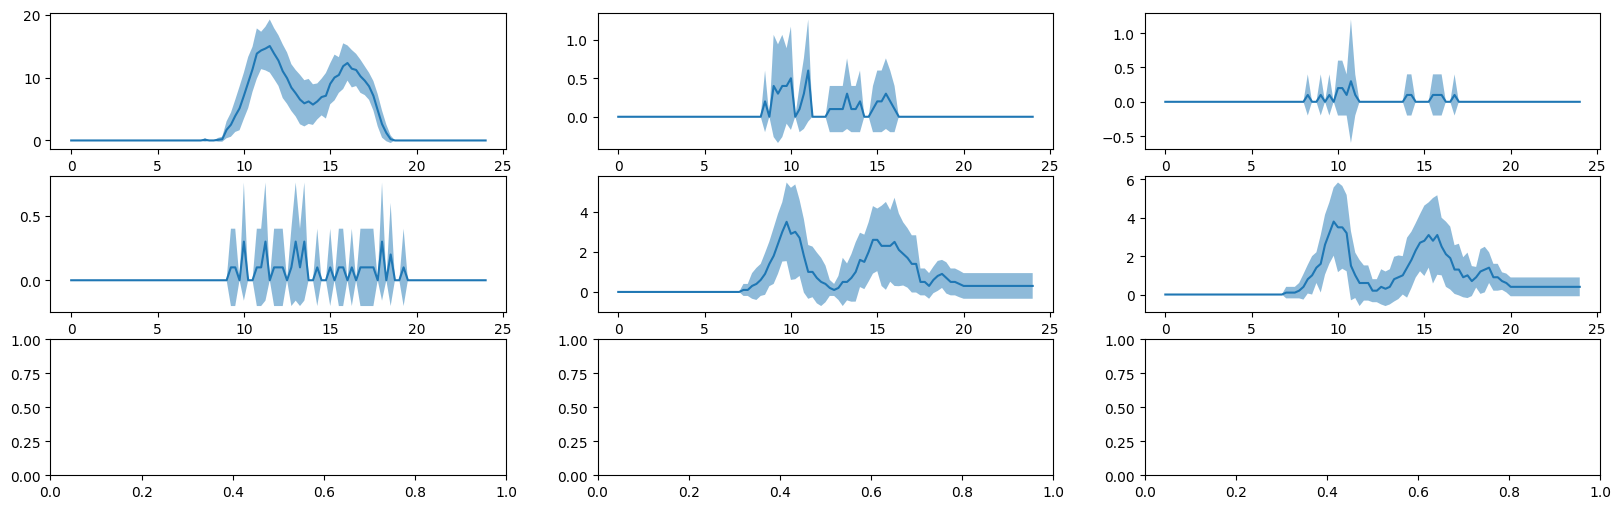

In [ ]:
fig, ax = plt.subplots(3, params.n_elevators + 1, figsize=(20, 6))


t = np.linspace(0, 24, buffers.shape[-1])

for buftype in [0, 1]:
    for i in range(params.n_elevators + 1):
        buf = buffers[:, buftype, i, :]
        ax[buftype, i].plot(t, np.mean(buf, axis=0))
        ax[buftype, i].fill_between(t, np.mean(buf, axis=0) - np.std(buf, axis=0), np.mean(buf, axis=0) + np.std(buf, axis=0), alpha=0.5)

for i in range(1, n_elevators + 1):
    buf = demands[:, i, :]
    ax[2, i].plot(t, np.mean(buf, axis=0))
    ax[2, i].fill_between(t, np.mean(buf, axis=0) - np.std(buf, axis=0), np.mean(buf, axis=0) + np.std(buf, axis=0), alpha=0.5)

# Looking at distributions

Gamma mean: 125.0
Time taken @ 1.4 m/s: 125.00000000000001
[107.16561484 144.18690374]


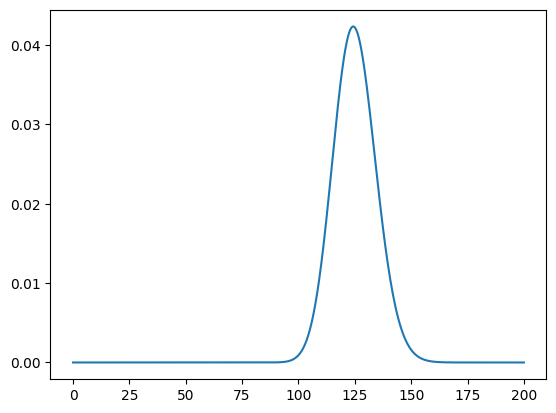

In [ ]:
from scipy.stats import gamma

dist = gamma(a=175, scale=1/1.4)

t = np.linspace(0, 200, 1000)

p = dist.pdf(t)

print("Gamma mean:", dist.mean())
print("Time taken @ 1.4 m/s:", 175 / 1.4)
print(dist.ppf([0.025, 0.975]))

plt.plot(t, p)
plt.show()

Lognorm mean: 125.62656510742514
Time taken @ 1.4 m/s: 125.00000000000001
[102.7518994 152.0653155]


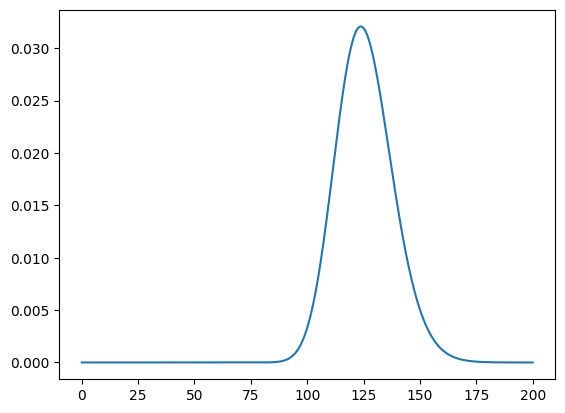

In [ ]:
from scipy.stats import lognorm

dist = lognorm(s=1/10, scale=175/1.4)

t = np.linspace(0, 200, 1000)

p = dist.pdf(t)

print("Lognorm mean:", dist.mean())
print("Time taken @ 1.4 m/s:", 175 / 1.4)
print(dist.ppf([0.025, 0.975]))

plt.plot(t, p)
plt.show()

In [ ]:
# Input
time = np.array([0, 4, 14])
value = np.array([1, 2, 3])

# New time range
new_time = np.linspace(0, 24, 25)

# Find indices for forward fill
indices = np.searchsorted(time, new_time, side='right') - 1

# Use indices to get values
new_value = value[indices]

print(new_time)
print(new_value)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24.]
[1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3]
